In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import glob
import shutil
import random

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [5]:
main_data_dir = os.getcwd() + "/Database_134_Angiograms"
print(os.listdir(main_data_dir))

['68_gt.pgm', '93_gt.pgm', '134_gt.pgm', '132.pgm', '94.pgm', '19.pgm', '114_gt.pgm', '61.pgm', '75_gt.pgm', '21.pgm', '23.pgm', '64_gt.pgm', '79.pgm', '33.pgm', '112.pgm', '100.pgm', '8_gt.pgm', '9_gt.pgm', '58_gt.pgm', '3_gt.pgm', '95_gt.pgm', '25_gt.pgm', '124_gt.pgm', '132_gt.pgm', '11_gt.pgm', '91_gt.pgm', '70_gt.pgm', '18.pgm', '103_gt.pgm', '100_gt.pgm', '113.pgm', '30.pgm', '81.pgm', '121.pgm', '123.pgm', '96_gt.pgm', '16_gt.pgm', '128_gt.pgm', '87.pgm', '10.pgm', '86.pgm', '40.pgm', '105_gt.pgm', '118.pgm', '52_gt.pgm', '83.pgm', '69_gt.pgm', '126.pgm', '73_gt.pgm', '62.pgm', '31.pgm', '35_gt.pgm', '21_gt.pgm', '22_gt.pgm', '127.pgm', '54.pgm', '98.pgm', '62_gt.pgm', '47.pgm', '72_gt.pgm', '20_gt.pgm', '1_gt.pgm', '54_gt.pgm', '67.pgm', '27_gt.pgm', '88_gt.pgm', '14.pgm', '104_gt.pgm', '67_gt.pgm', '19_gt.pgm', '7.pgm', '41.pgm', '.ipynb_checkpoints', '126_gt.pgm', '42.pgm', '45_gt.pgm', '36.pgm', '78.pgm', '89_gt.pgm', '11.pgm', '46_gt.pgm', '28_gt.pgm', '4_gt.pgm', '47_gt.pg

In [8]:
from glob import glob
all_img_paths = glob(main_data_dir + "/*")

img_paths = [x for x in all_img_paths if "gt" not in x]
msk_paths = [x for x in all_img_paths if "gt" in x]

print(len(img_paths))
print(len(msk_paths))

134
134


In [13]:
import os
import shutil

# Tạo thư mục để lưu các file image và mask
os.makedirs('images', exist_ok=True)
os.makedirs('masks', exist_ok=True)

for file_path in file_list:
    file_name = os.path.basename(file_path)
    if '_gt' in file_name:  # File mask
        shutil.move(file_path, os.path.join('masks', file_name))
        print(f"Đã di chuyển {file_name} vào thư mục masks.")
    else:  # File image
        shutil.move(file_path, os.path.join('images', file_name))
        print(f"Đã di chuyển {file_name} vào thư mục images.")


Đã di chuyển 68_gt.pgm vào thư mục masks.
Đã di chuyển 93_gt.pgm vào thư mục masks.
Đã di chuyển 134_gt.pgm vào thư mục masks.
Đã di chuyển 132.pgm vào thư mục images.
Đã di chuyển 94.pgm vào thư mục images.
Đã di chuyển 19.pgm vào thư mục images.
Đã di chuyển 114_gt.pgm vào thư mục masks.
Đã di chuyển 61.pgm vào thư mục images.
Đã di chuyển 75_gt.pgm vào thư mục masks.
Đã di chuyển 21.pgm vào thư mục images.
Đã di chuyển 23.pgm vào thư mục images.
Đã di chuyển 64_gt.pgm vào thư mục masks.
Đã di chuyển 79.pgm vào thư mục images.
Đã di chuyển 33.pgm vào thư mục images.
Đã di chuyển 112.pgm vào thư mục images.
Đã di chuyển 100.pgm vào thư mục images.
Đã di chuyển 8_gt.pgm vào thư mục masks.
Đã di chuyển 9_gt.pgm vào thư mục masks.
Đã di chuyển 58_gt.pgm vào thư mục masks.
Đã di chuyển 3_gt.pgm vào thư mục masks.
Đã di chuyển 95_gt.pgm vào thư mục masks.
Đã di chuyển 25_gt.pgm vào thư mục masks.
Đã di chuyển 124_gt.pgm vào thư mục masks.
Đã di chuyển 132_gt.pgm vào thư mục masks.
Đã di ch

In [3]:
images_dir = '/home/ly/git/DecodeItAll/bio_seman_seg/dataset/dca/images'
masks_dir = '/home/ly/git/DecodeItAll/bio_seman_seg/dataset/dca/masks'

training_dir = '/home/ly/git/DecodeItAll/bio_seman_seg/dataset/dca/training'
testing_dir = '/home/ly/git/DecodeItAll/bio_seman_seg/dataset/dca/testing'

train_image_dir = os.path.join(training_dir, "train image")
train_mask_dir = os.path.join(training_dir, "train mask")
test_image_dir = os.path.join(testing_dir, "test image")
test_mask_dir = os.path.join(testing_dir, "test mask")

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)


image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
mask_files = [f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]


train_size = 0.8  
num_train = int(len(image_files) * train_size)


train_image_files = image_files[:num_train]
train_mask_files = mask_files[:num_train]


test_image_files = image_files[num_train:]
test_mask_files = mask_files[num_train:]


def move_files(source_dir, files, destination_dir):
    for file in files:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_dir, file)
        if os.path.isfile(source_path):  
            shutil.copy(source_path, destination_path)

move_files(images_dir, train_image_files, train_image_dir)
move_files(masks_dir, train_mask_files, train_mask_dir)

move_files(images_dir, test_image_files, test_image_dir)
move_files(masks_dir, test_mask_files, test_mask_dir)


In [11]:
path = os.getcwd()
path_parts = path.split("/")  
path_with_backslash = "\\".join(path_parts)  
print(path_with_backslash)

\home\ly\git\DecodeItAll\bio_seman_seg\dataset\dca


In [12]:
bio_seg_dir = "/".join(path_with_backslash.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/ly/git/DecodeItAll/bio_seman_seg
True


In [13]:
data_dir = bio_seg_dir + "/dataset/dca"
print(os.listdir(data_dir))

['.ipynb_checkpoints', 'masks', 'training', 'Custom-dca.ipynb', 'testing', 'images', 'Database_134_Angiograms']


In [16]:
train_dir = data_dir + "/training"
test_dir = data_dir + "/testing"

train_img_dir = train_dir + "/train image"
train_mask_dir = train_dir + "/train mask"

test_img_dir = test_dir + "/test image"

print(f"No. Train Img: {len(os.listdir(train_img_dir))}")
print(f"No. Train Msk: {len(os.listdir(train_mask_dir))}")
print(f"No. Test Img: {len(os.listdir(test_img_dir))}")

No. Train Img: 107
No. Train Msk: 107
No. Test Img: 27


In [22]:
class DcaDS(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(train_img_dir + "/*"))
        self.msks = sorted(glob(train_mask_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

107


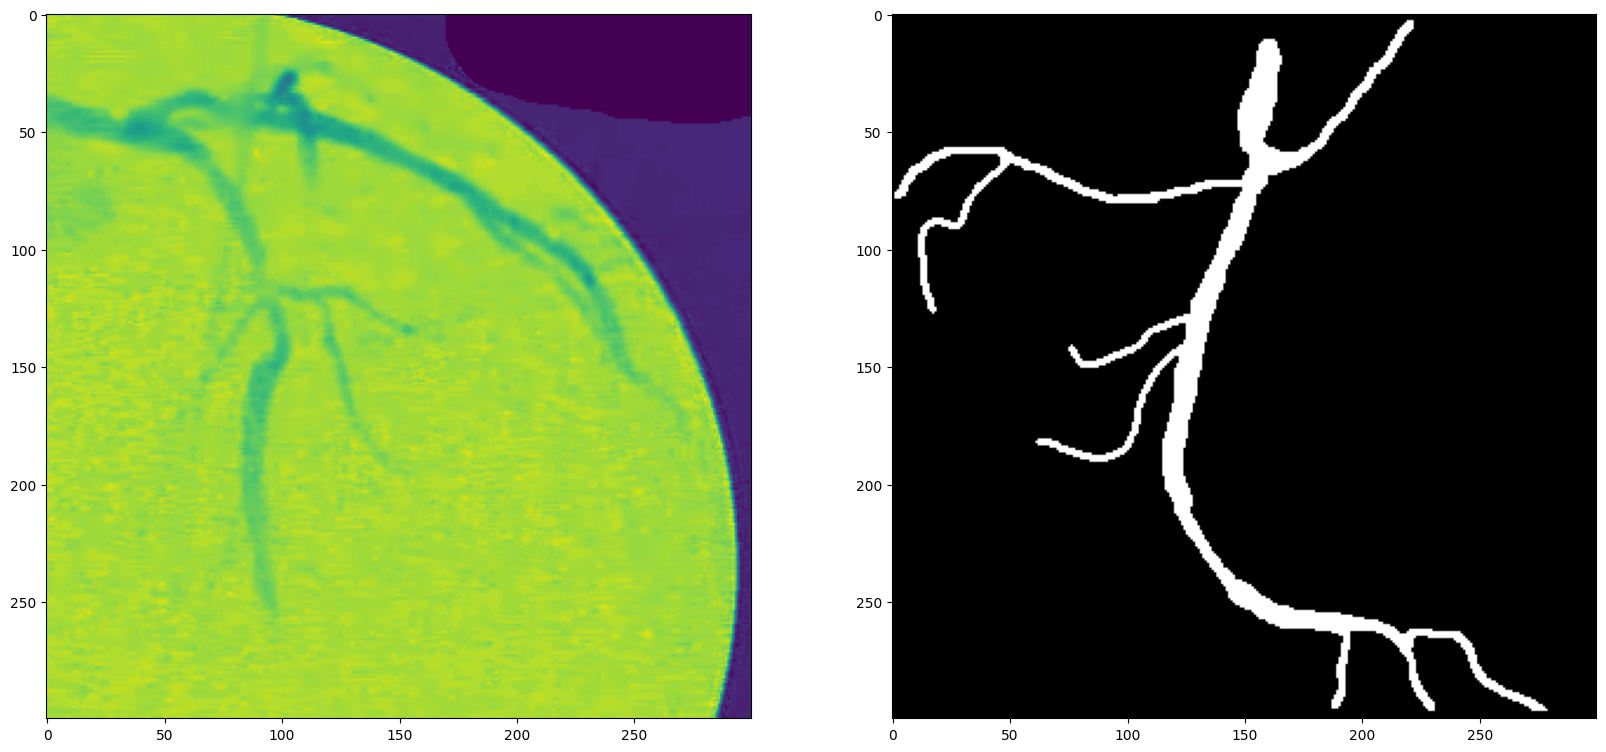

In [25]:
transform = transforms.Compose(
    [
        # transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        # transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

train_ds = DcaDS(transform = transform, target_transform=target_transform)

print(len(train_ds))

img, msk = train_ds[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [26]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

6
